In [1]:
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

from scipy import stats

import sys 
sys.path.append("../")
from KDG import KDG

Using TensorFlow backend.


# Experiment Parameters

In [2]:
max_depth = 5
n_estimators = 2
num_trials = 500

# Data Generation

# Construct & Train Network

## Keurnal Networks

In [3]:
def train_AKN(X, y):
    X_transform, X, y_transform, y = train_test_split(X, y, test_size = .75)
    #X_transform, y_transform = X, y
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth)

    rfc.fit(X, y)

    predicted_leaf_ids_across_trees = np.array([keras.utils.to_categorical(np.unique(tree.apply(X), return_inverse = True)[1], num_classes = 2 ** (max_depth + 1)) for tree_idx, tree in enumerate(rfc.estimators_)])
    length = np.shape(predicted_leaf_ids_across_trees)[-1]
    forest_partition_ids = np.matmul(predicted_leaf_ids_across_trees[0], np.expand_dims(np.logspace(0, length, num = length, base = 2), axis = 1)) + np.matmul(predicted_leaf_ids_across_trees[1], np.expand_dims(np.logspace(length, 2*length, num = length, base = 2), axis = 1))
    _, forest_partition_ids = np.unique(forest_partition_ids, return_inverse = True)

    return KDG().fit(X, y, forest_partition_ids)

In [4]:
def generate_gaussian_parity(n):
    means = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]])
    X = np.concatenate([np.random.multivariate_normal(mean, 0.1 * np.eye(len(mean)),
                                                 size=int(n / 4)) for mean in means])

    y = np.concatenate([np.ones(int(n / 4)) * int(idx < 2) for idx in range(len(means))])

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

In [5]:
xx, yy = np.meshgrid(np.arange(-1, 1, (2) / 100),
                      np.arange(-1, 1, (2) / 100))

def pdf(x):
    mu01, mu02, mu11, mu12 = [[-1, -1], [1, 1], [-1, 1], [1, -1]]
    cov = 0.1 * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    return p1/(p0+p1)

true_posterior = [pdf(x) for x in tqdm(np.c_[xx.ravel(), yy.ravel()])]

In [6]:
def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension
    """
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)

In [7]:
X, y = generate_gaussian_parity(n = int(1e5))
X_test, y_test = generate_gaussian_parity(n = 1000)

In [8]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth)

    rfc.fit(X, y)
    xx, yy = np.meshgrid(np.arange(-1, 1, (2) / 100),
                      np.arange(-1, 1, (2) / 100))
    return rfc.predict_proba(X_test), rfc.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    kdg = train_AKN(X, y)
    y_proba_unnormalized = kdg.predict_proba(X_test)

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
        
    y_proba_unnormalized_grid = kdg.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    y_proba_grid = y_proba_unnormalized_grid.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba_grid[:, y_val] /= np.sum(y_proba_unnormalized_grid, axis = 1)
    
    return y_proba, y_proba_grid

In [9]:
def clipped_mean(ra, low = 25, high = 75):
    ra = np.array(ra)
    lower_val = np.nanpercentile(ra, low)
    higher_val = np.nanpercentile(ra, high)
    return np.mean(ra[np.where((ra >= lower_val) & (ra <= higher_val))[0]])

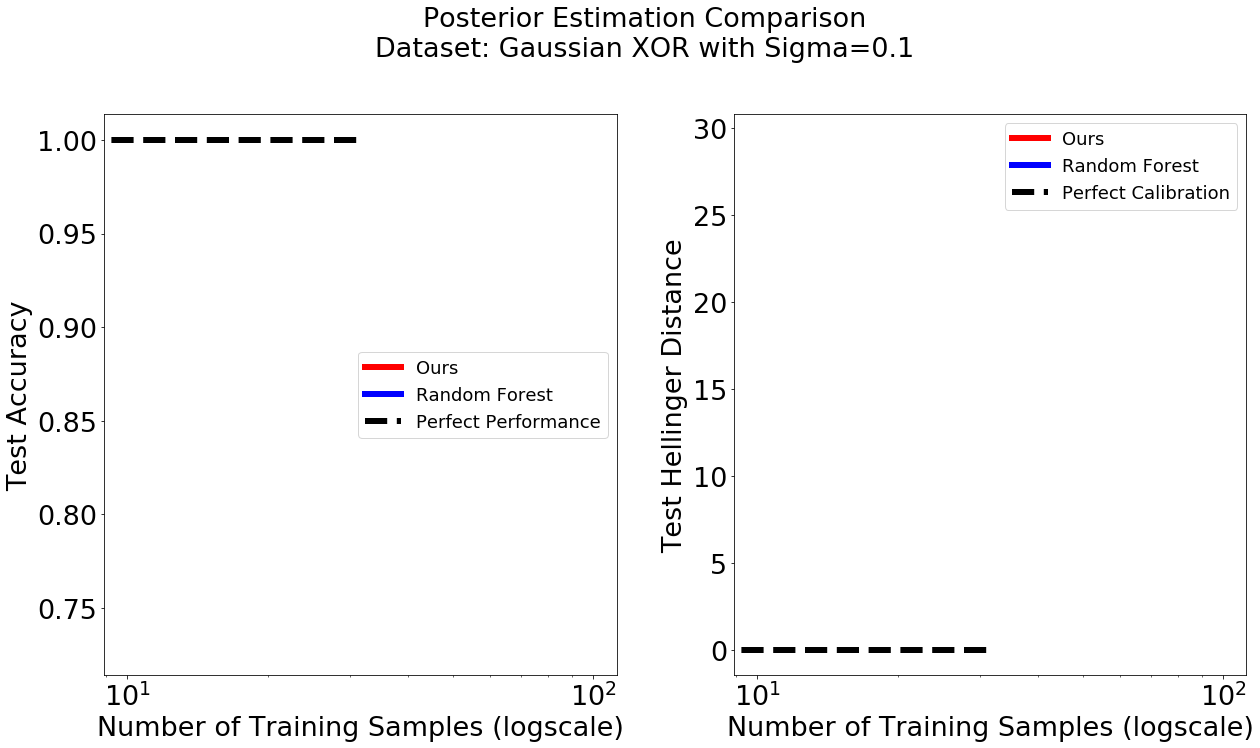

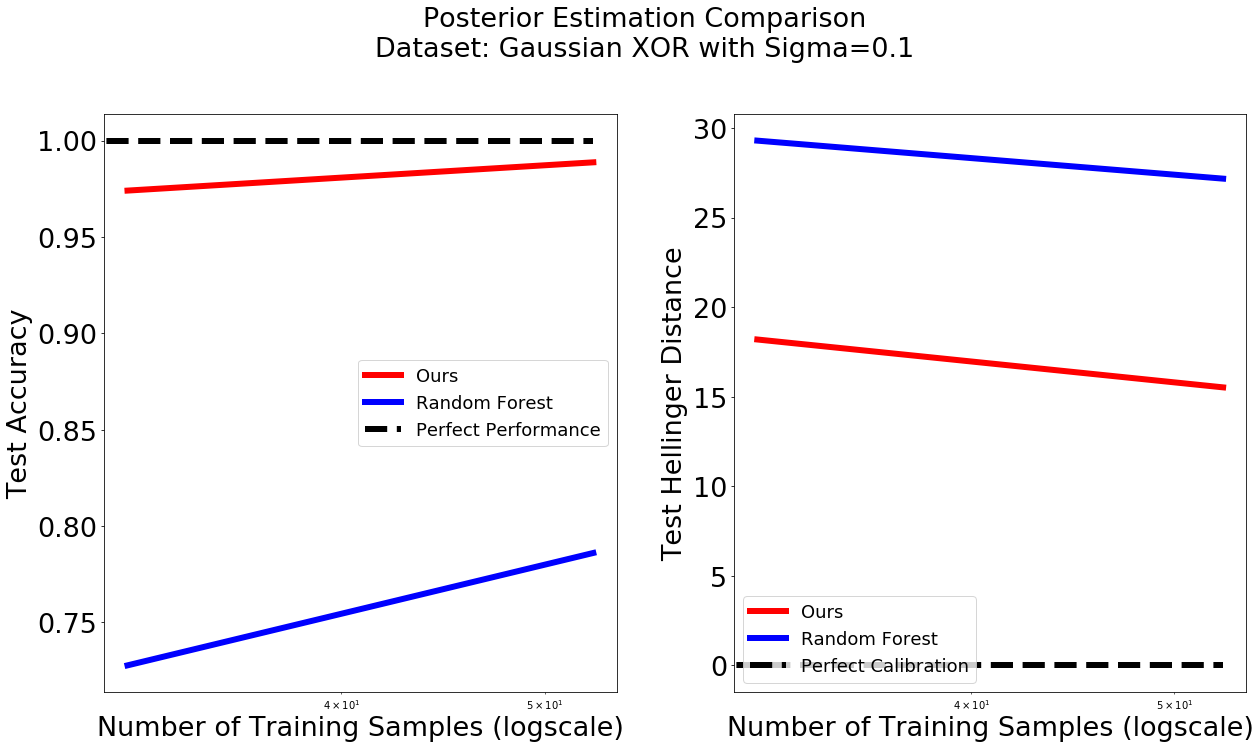

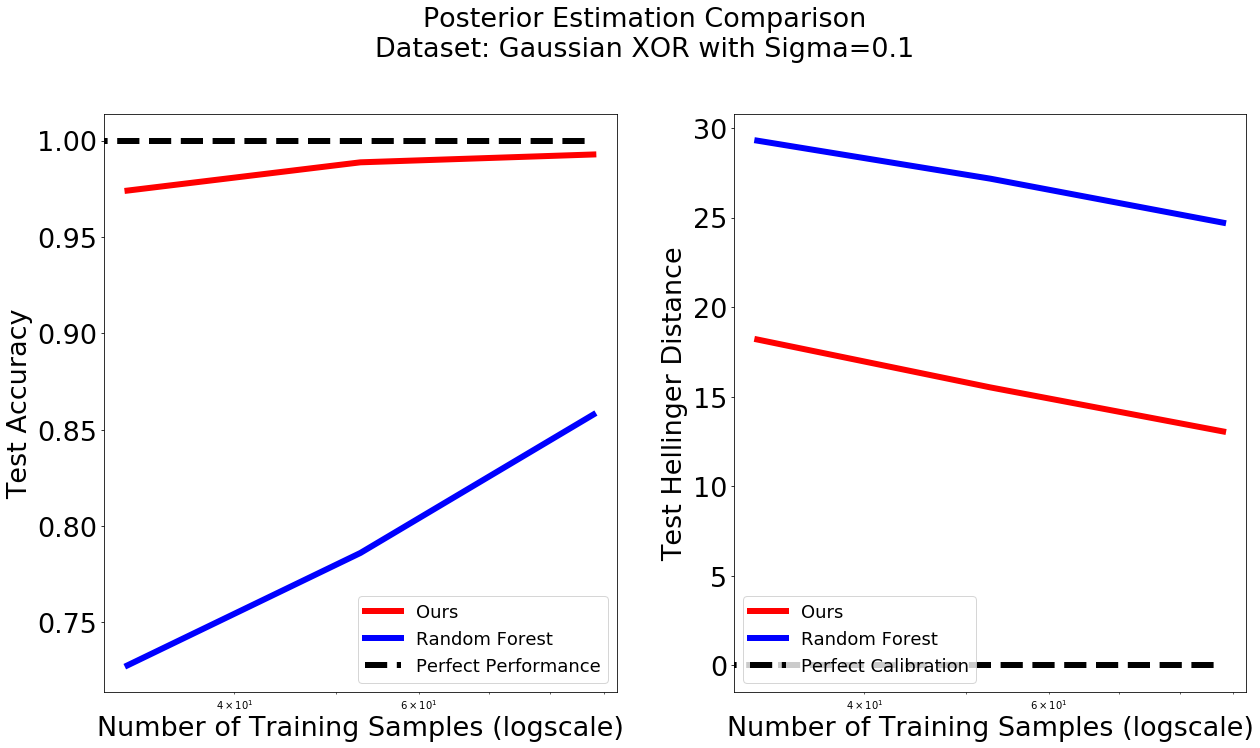

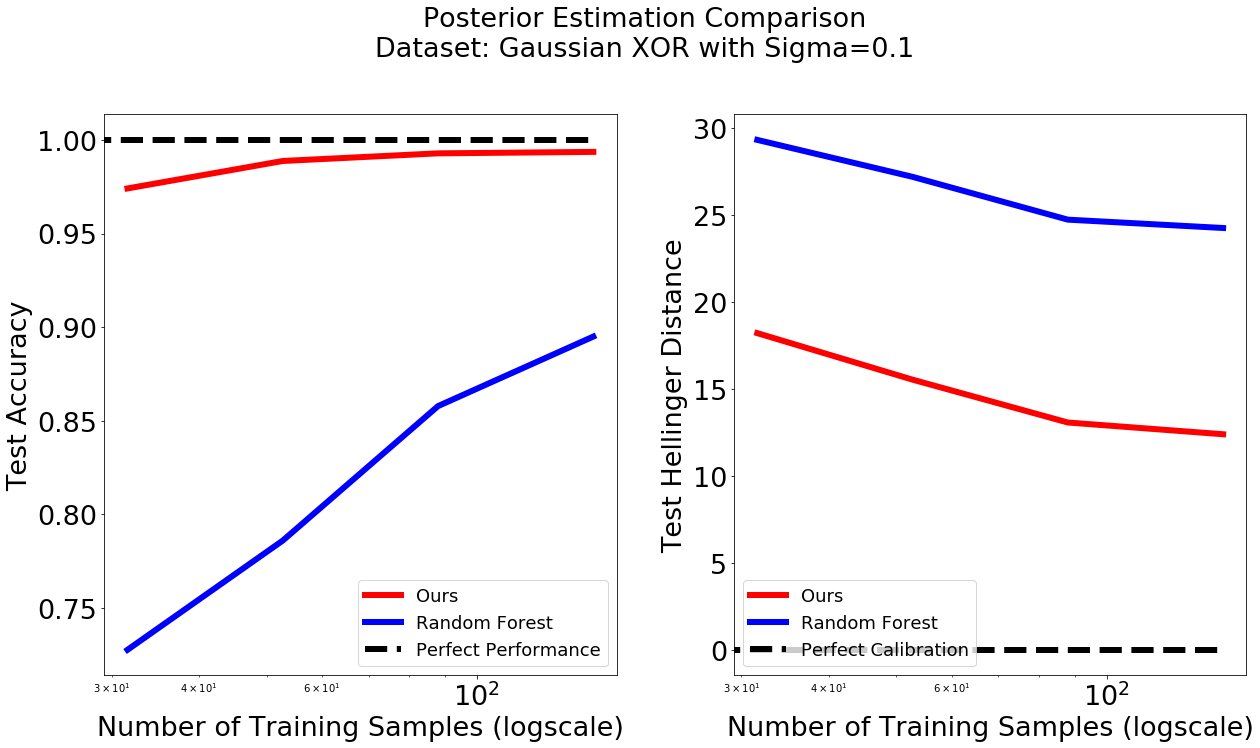

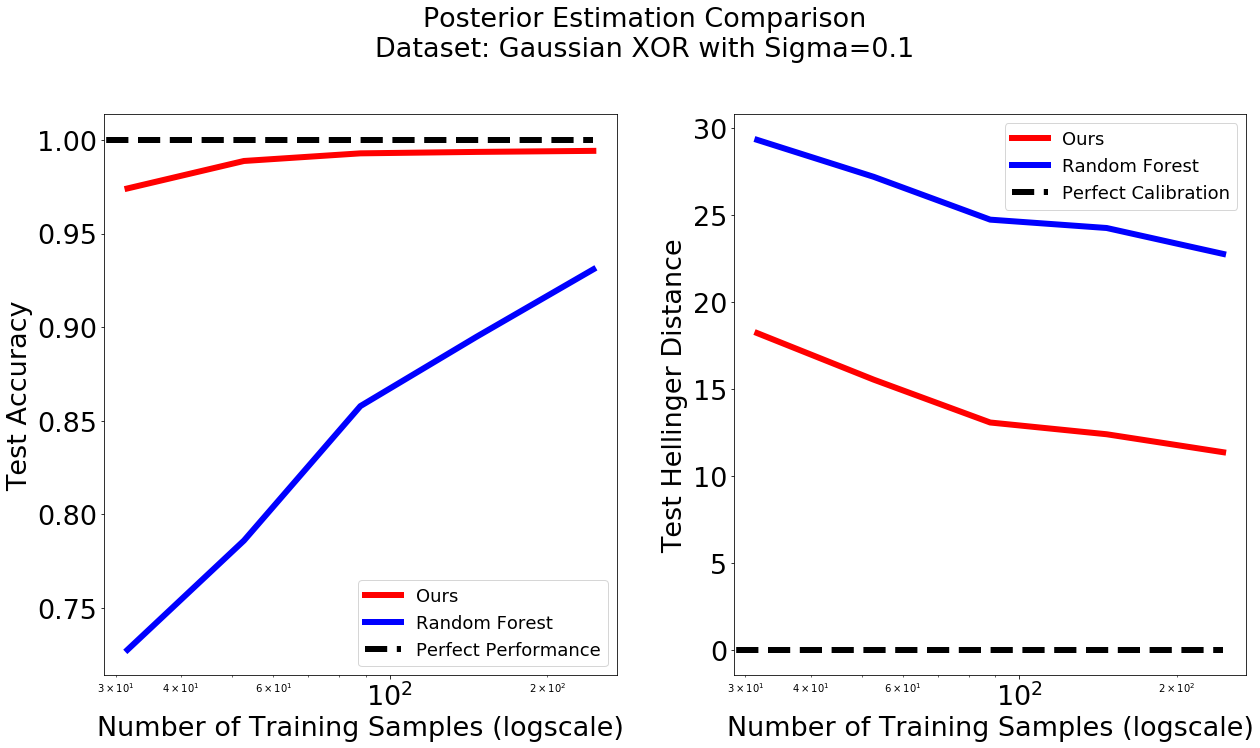

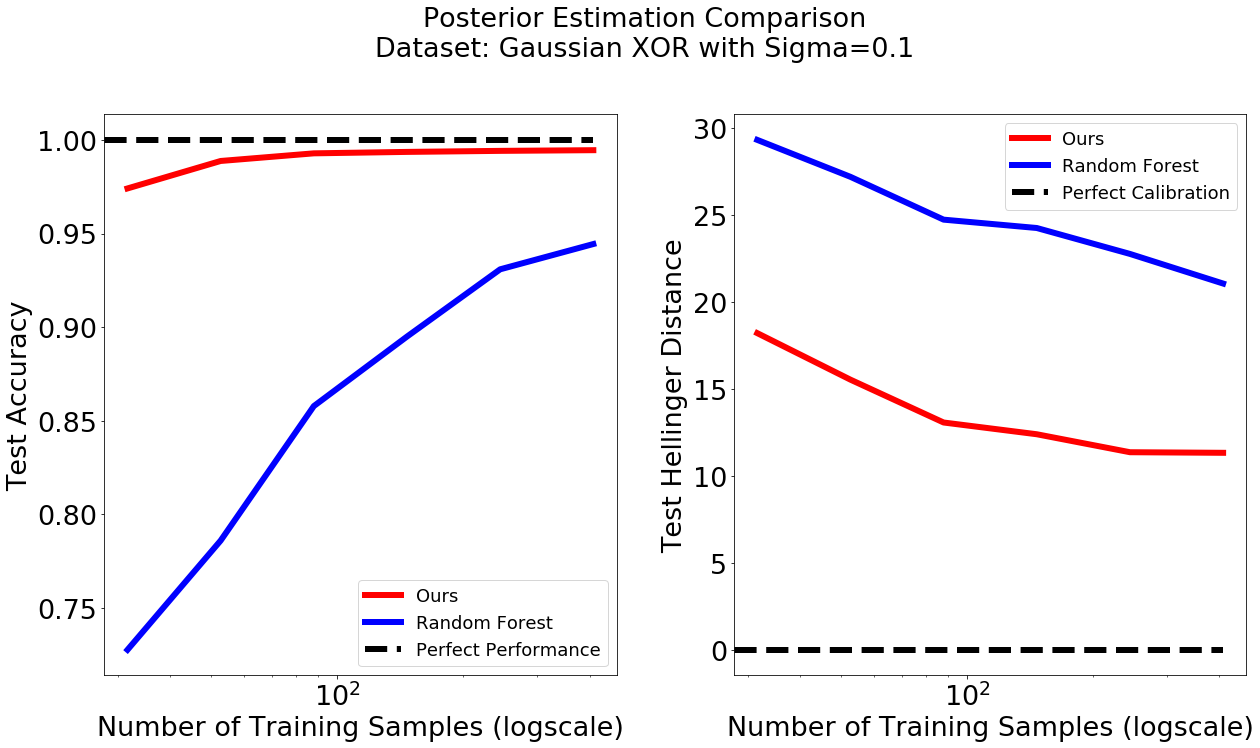

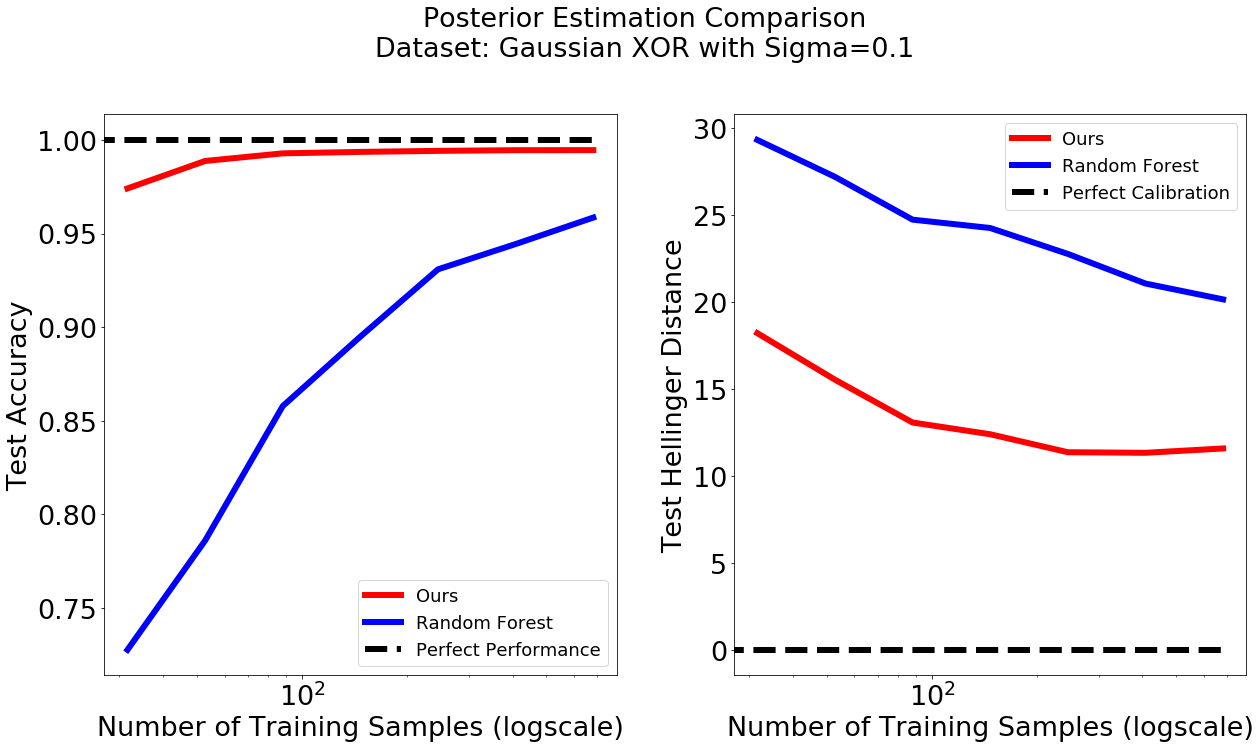

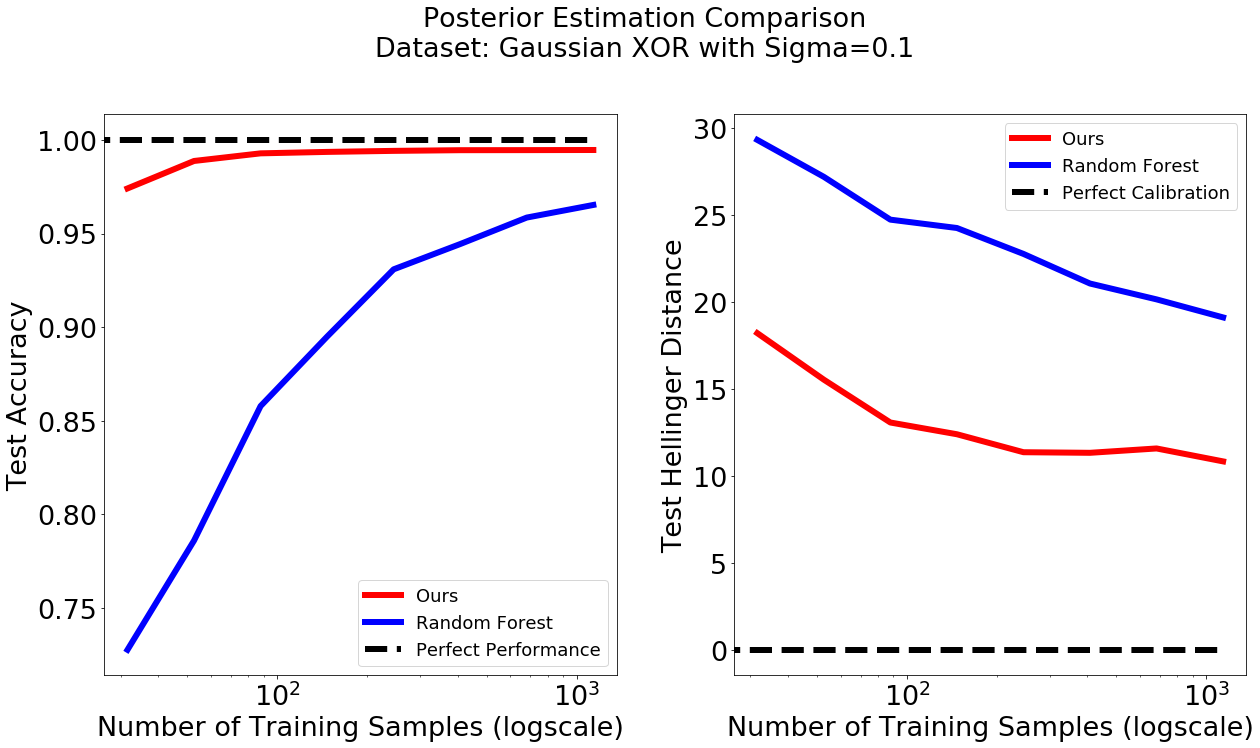

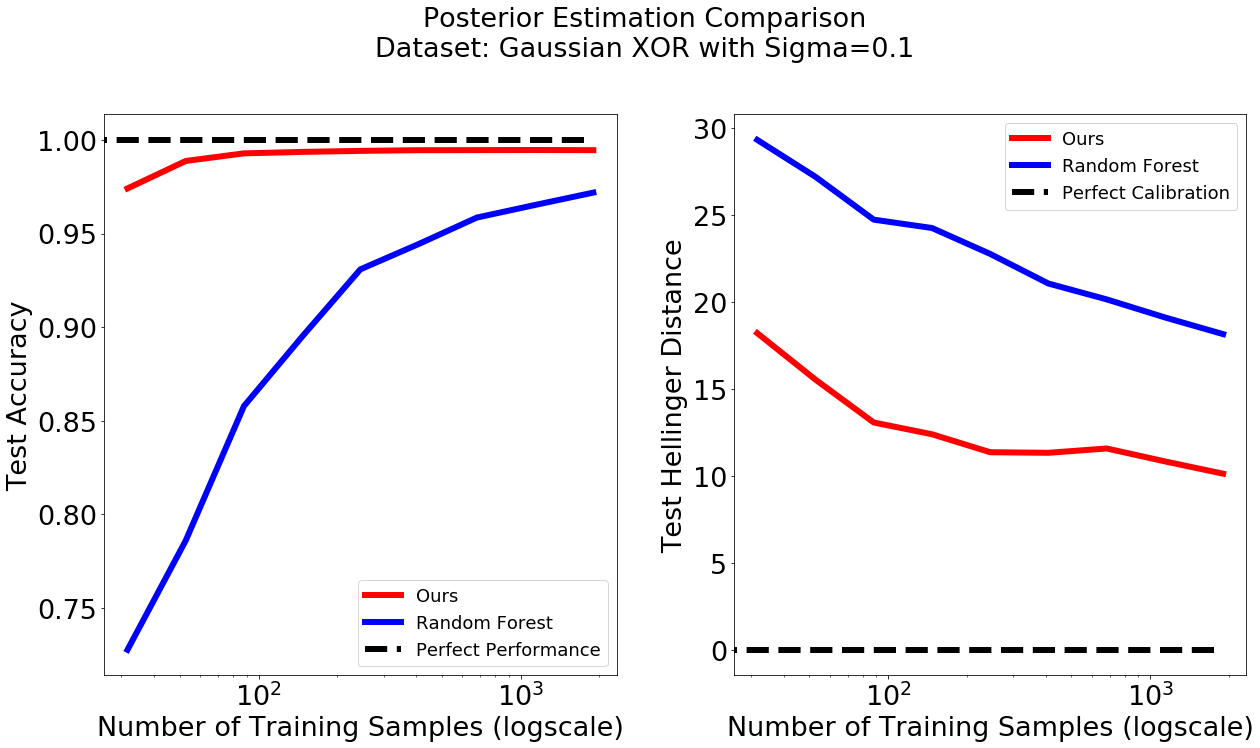

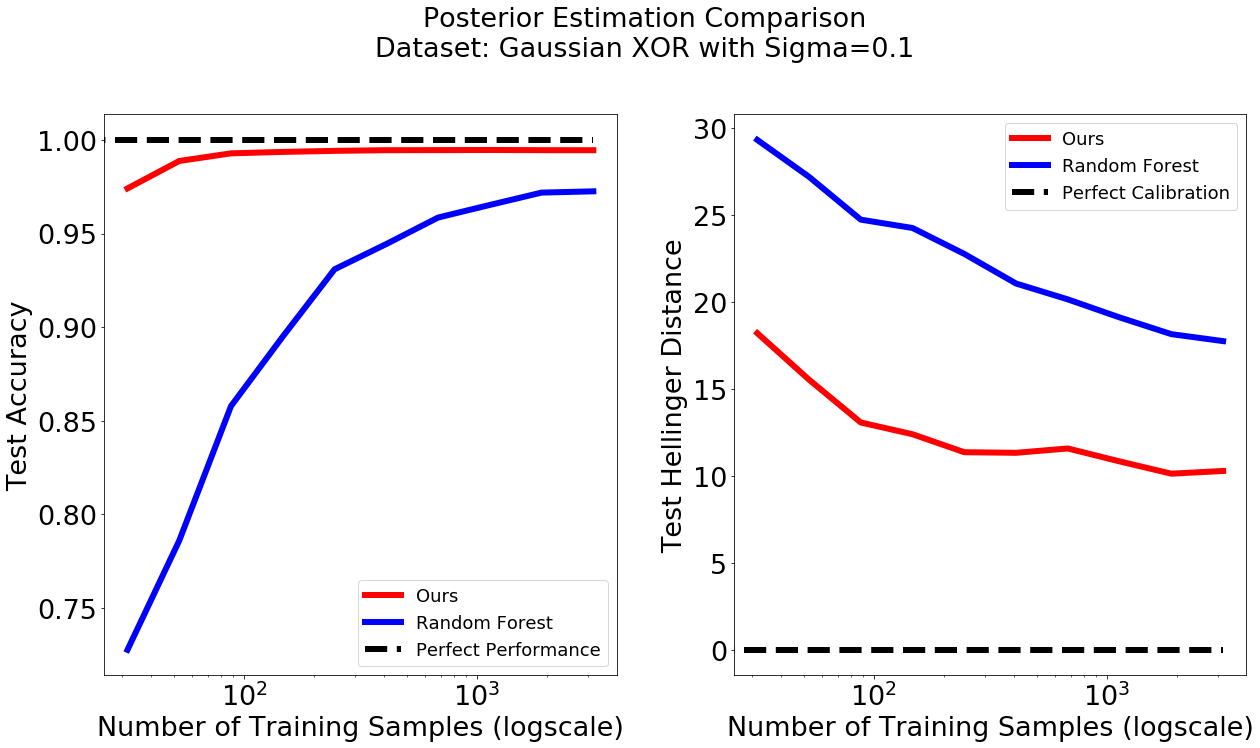

In [11]:
KDE_acc_means = []
network_acc_means = []

KDE_acc_stds = []
network_acc_stds = []

KDE_brier_means = []
network_brier_means = []

KDE_brier_stds = []
network_brier_stds = []
n_ra = np.logspace(1.5, 3.5, num = 10, base = 10)
ticks = np.arange(np.min(n_ra), np.max(n_ra), step = int((np.max(n_ra) - np.min(n_ra)) // 4))
ticks_ra = np.array([int(str(tick)[:1]) * 10 ** int(np.log10(tick)) for tick in ticks])
for n in tqdm(n_ra):
    network_y_test_proba_across_trials = np.array([get_network_y_proba(X, y, n, X_test) for _ in tqdm(range(num_trials))])
    KDE_y_test_proba_across_trials = np.array([get_KDE_y_proba(X, y, n, X_test) for _ in tqdm(range(num_trials))])

    
    KDE_accs_across_trials = []
    network_accs_across_trials = []
    KDE_briers_across_trials = []
    network_briers_across_trials = []
    for trial_idx in range(num_trials):
        KDE_accs_across_trials.append(np.nanmean(np.argmax(KDE_y_test_proba_across_trials[trial_idx, 0], axis = 1) == y_test))
        network_accs_across_trials.append(np.nanmean(np.argmax(network_y_test_proba_across_trials[trial_idx, 0], axis = 1) == y_test))
        
        KDE_briers_across_trials.append(hellinger_explicit(KDE_y_test_proba_across_trials[trial_idx, 1][:, 0], true_posterior))
        network_briers_across_trials.append(hellinger_explicit(network_y_test_proba_across_trials[trial_idx, 1][:, 0], true_posterior))
        
    KDE_acc_means.append(clipped_mean(KDE_accs_across_trials))
    network_acc_means.append(clipped_mean(network_accs_across_trials))
    
    KDE_brier_means.append(clipped_mean(KDE_briers_across_trials, low = 0, high = 25))
    network_brier_means.append(clipped_mean(network_briers_across_trials, low = 0, high = 25))

    figs, ax = plt.subplots(1, 2, figsize = (18, 9))
    figs.set_facecolor("white")

    ax[0].tick_params(axis='both', which='major', labelsize=27)
    ax[0].plot(n_ra[:len(KDE_acc_means)] , KDE_acc_means, label = "Ours", c = "red")
    ax[0].plot(n_ra[:len(KDE_acc_means)], network_acc_means, label = "Random Forest", c = "blue")
    ax[0].hlines(1.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Performance", color = "black")
    ax[0].legend(fontsize = 18)
    ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[0].set_ylabel("Test Accuracy", fontsize = 27)
    ax[0].set_xscale("log")

    ax[1].tick_params(axis='both', which='major', labelsize=27)
    ax[1].plot(n_ra[:len(KDE_acc_means)] , KDE_brier_means, label = "Ours", c = "red")
    ax[1].plot(n_ra[:len(KDE_acc_means)], network_brier_means, label = "Random Forest", c = "blue")
    ax[1].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
    ax[1].legend(fontsize = 18)
    ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[1].set_ylabel("Test Hellinger Distance", fontsize = 27)
    ax[1].set_xscale("log")

    figs.tight_layout()

    figs.suptitle("Posterior Estimation Comparison\nDataset: Gaussian XOR with Sigma=0.1", fontsize=27, y = 1.15)

    plt.show()

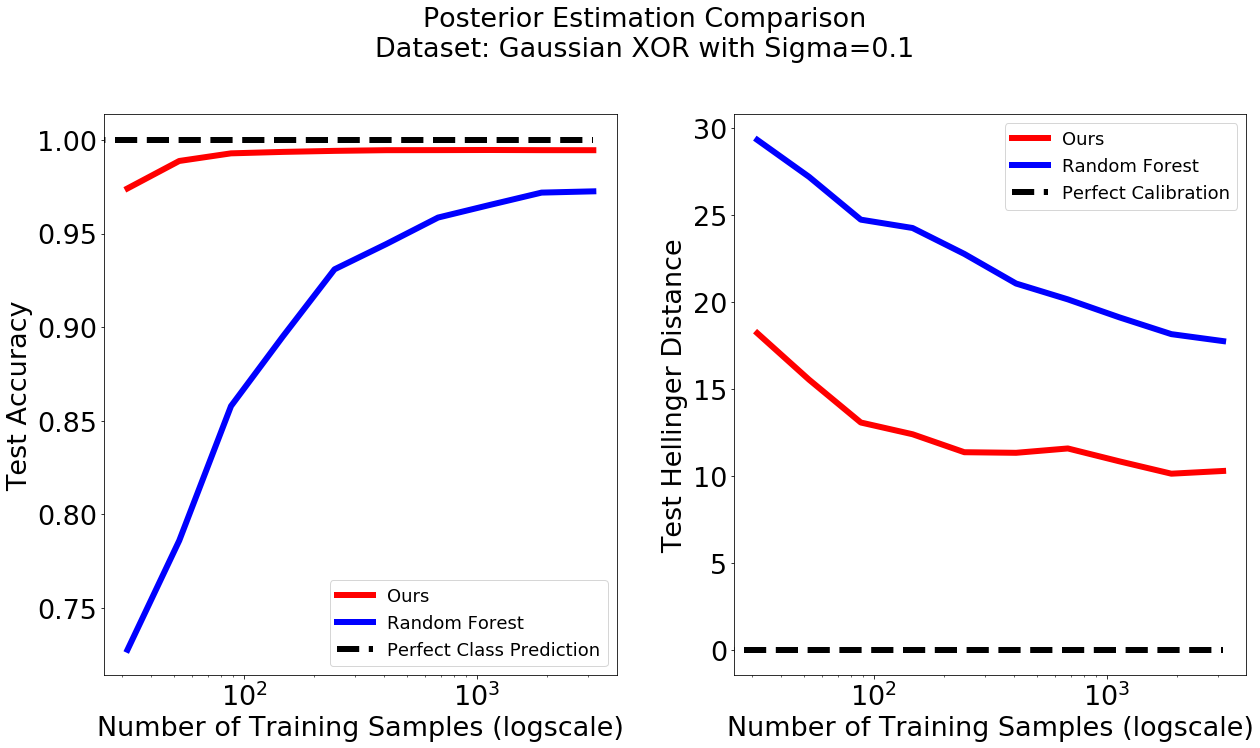

In [15]:
figs, ax = plt.subplots(1, 2, figsize = (18, 9))
figs.set_facecolor("white")

ax[0].tick_params(axis='both', which='major', labelsize=27)
ax[0].plot(n_ra , KDE_acc_means, label = "Ours", c = "red")
ax[0].plot(n_ra, network_acc_means, label = "Random Forest", c = "blue")
ax[0].hlines(1.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
ax[0].legend(fontsize = 18)
ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[0].set_ylabel("Test Accuracy", fontsize = 27)
ax[0].set_xscale("log")

ax[1].tick_params(axis='both', which='major', labelsize=27)
ax[1].plot(n_ra , KDE_brier_means, label = "Ours", c = "red")
ax[1].plot(n_ra, network_brier_means, label = "Random Forest", c = "blue")
ax[1].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
ax[1].legend(fontsize = 18)
ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[1].set_ylabel("Test Hellinger Distance", fontsize = 27)
ax[1].set_xscale("log")


figs.tight_layout()

figs.suptitle("Posterior Estimation Comparison\nDataset: Gaussian XOR with Sigma=0.1", fontsize=27, y = 1.15)


plt.show()